In [47]:
import numpy as np
import cv2
from os import listdir
import tensorflow as tf
import pickle
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Reshape, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import regularizers
import matplotlib.pyplot as plt
import pathlib

%matplotlib inline

In [26]:
image_gen_train = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.08,
    zoom_range=0.07,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255,
    brightness_range=[0.3, 0.6],
    width_shift_range=0.07,
    height_shift_range=0.07
)

image_gen = ImageDataGenerator(
    rescale = 1/255,
)

In [27]:
# Define input directory
input_folder = pathlib.Path("split_data/")

In [32]:
batch_size=32

training_data = image_gen_train.flow_from_directory(
    input_folder / 'train',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42
)

validation_data = image_gen.flow_from_directory(
    input_folder / 'val',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size,
    seed = 42
)

test_data = image_gen.flow_from_directory(
    input_folder / 'test',
    class_mode="binary",
    target_size = (224, 224),
    batch_size = batch_size,
    shuffle = False,
    seed = 42
)

Found 19290 images belonging to 2 classes.
Found 4132 images belonging to 2 classes.
Found 4136 images belonging to 2 classes.


In [53]:
from tensorflow.keras.models import Model

# Define input shape and batch size
input_shape = (224, 224, 3)
batch_size = 32
input_tensor = Input(shape=input_shape)

# Load the base model with the input tensor and predefined input shape
base_model = MobileNet(input_tensor=input_tensor, include_top=False, weights='imagenet')

# Freeze all layers in the base model except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add additional layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1, activation='sigmoid')(x)  

# Create the complete model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Print the model summary
model.summary()

C:\Users\hp\AppData\Local\Temp\ipykernel_16836\2358071954.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,279,489 (16.32 MB)

 Trainable params: 2,101,249 (8.02 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

In [34]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [35]:
epochs = 10

history = model.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/10


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


603/603 ━━━━━━━━━━━━━━━━━━━━ 1326s 2s/step - accuracy: 0.8659 - loss: 0.3678 - val_accuracy: 0.9475 - val_loss: 0.1621
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1503s 2s/step - accuracy: 0.9359 - loss: 0.1795 - val_accuracy: 0.9470 - val_loss: 0.1605
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1557s 3s/step - accuracy: 0.9416 - loss: 0.1654 - val_accuracy: 0.9472 - val_loss: 0.1591
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1605s 3s/step - accuracy: 0.9480 - loss: 0.1543 - val_accuracy: 0.8906 - val_loss: 0.3436
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1612s 3s/step - accuracy: 0.9435 - loss: 0.1578 - val_accuracy: 0.9337 - val_loss: 0.1839
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1558s 3s/step - accuracy: 0.9501 - loss: 0.1448 - val_accuracy: 0.8817 - val_loss: 0.3682
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1560s 3s/step - accuracy: 0.9478 - loss: 0.1491 - val_accuracy: 0.9514 - val_loss: 0.1380
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1564s 3s/step - accuracy: 0.9504 - loss: 0.1413 - val_accurac

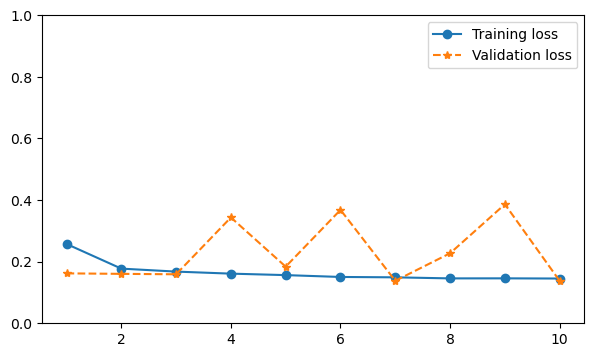

In [44]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
plt.ylim(0, 1)
ax.legend()
plt.show()

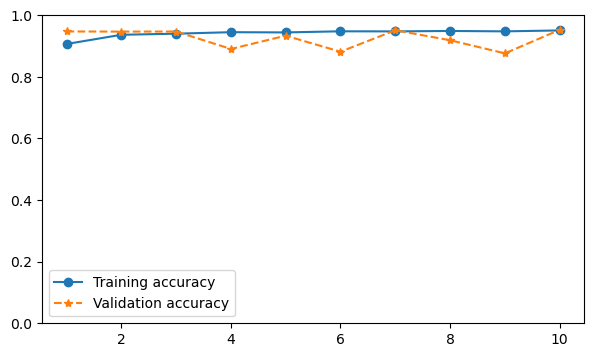

In [43]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
plt.ylim(0, 1)
ax.legend()
plt.show()


In [38]:
model.evaluate(test_data)

130/130 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9505 - loss: 0.1306


[0.13619652390480042, 0.9455996155738831]

130/130 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step
Confusion matrix:
 [[1976   92]
 [ 133 1935]]


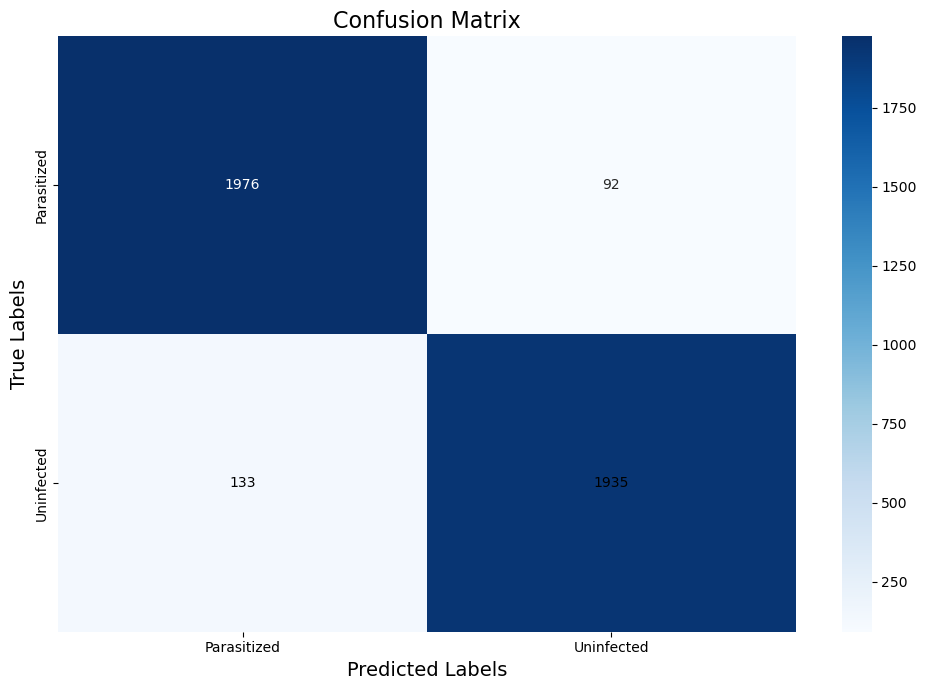

              precision    recall  f1-score   support

 Parasitized       0.94      0.96      0.95      2068
  Uninfected       0.95      0.94      0.95      2068

    accuracy                           0.95      4136
   macro avg       0.95      0.95      0.95      4136
weighted avg       0.95      0.95      0.95      4136



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test data
predictions = model.predict(test_data)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get true classes
true_classes = test_data.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)

for i, value in enumerate(conf_matrix[1]):
    plt.text(i + 0.5, 1.5, str(value), ha="center", va="center", color="black")

plt.xlabel('Predicted Labels', fontsize=14)  # Increase label font size for better visibility
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Ensure tight layout to prevent labels from overlapping
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys()))